In [41]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [42]:
img_size = 256
BATCH_size = 30
CHANNELS=3
EPOCHS = 50

In [43]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Defects",
    shuffle = True,
    image_size = (img_size , img_size),
    batch_size = BATCH_size
)

Found 1656 files belonging to 6 classes.


In [44]:
c_names = dataset.class_names
c_names

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

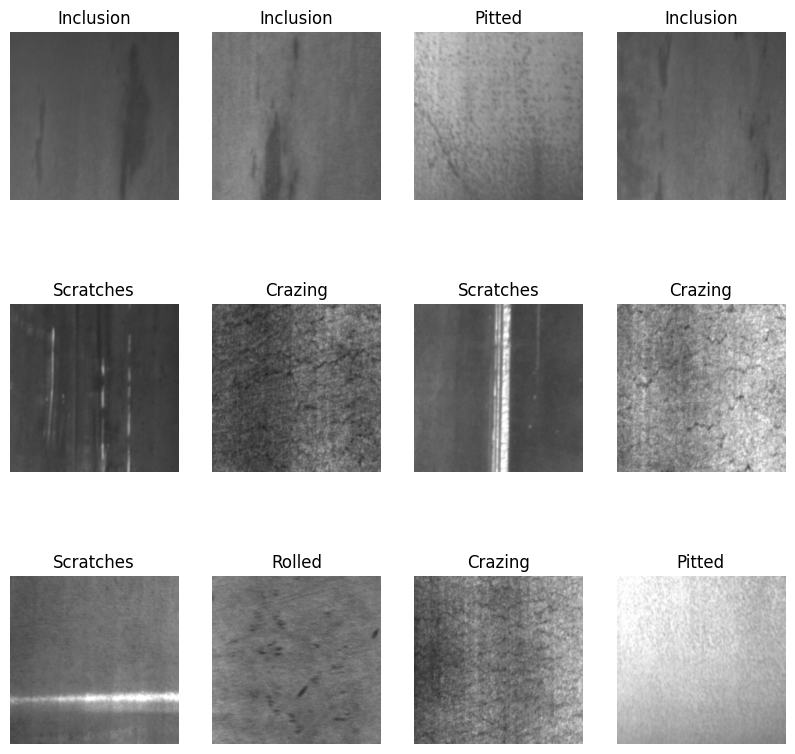

In [45]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(c_names[label_batch[i]])
        plt.axis("off")

In [46]:
train_size = 0.8
len(dataset)*train_size

44.800000000000004

In [47]:
def get_dataset_partitions_tf(ds, test_part = 0.1 , train_part=0.8 , val_part =0.1, shuffle = True ,shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed =10)
        
    test_size = int(test_part*ds_size)
    train_size = int(train_part*ds_size)
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [48]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [49]:
len(val_ds)

7

In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [51]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [52]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [60]:
input_shape = (BATCH_size,img_size,img_size,CHANNELS)
n_classes = 6


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [61]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (30, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (30, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (30, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (30, 62, 62, 64)         0         
 g2D)                                                

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [63]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
44/44 [==============================] - 56s 1s/step - loss: 1.7797 - accuracy: 0.1944 - val_loss: 1.7378 - val_accuracy: 0.2000
Epoch 2/50
44/44 [==============================] - 53s 1s/step - loss: 1.6045 - accuracy: 0.2724 - val_loss: 1.3354 - val_accuracy: 0.3905
Epoch 3/50
44/44 [==============================] - 53s 1s/step - loss: 1.3699 - accuracy: 0.4421 - val_loss: 1.1880 - val_accuracy: 0.5524
Epoch 4/50
44/44 [==============================] - 52s 1s/step - loss: 1.1458 - accuracy: 0.5741 - val_loss: 1.0097 - val_accuracy: 0.6381
Epoch 5/50
44/44 [==============================] - 54s 1s/step - loss: 0.9295 - accuracy: 0.6543 - val_loss: 0.7113 - val_accuracy: 0.7286
Epoch 6/50
44/44 [==============================] - 52s 1s/step - loss: 0.7575 - accuracy: 0.7099 - val_loss: 0.5404 - val_accuracy: 0.8190
Epoch 7/50
44/44 [==============================] - 52s 1s/step - loss: 0.6184 - accuracy: 0.7832 - val_loss: 0.4912 - val_accuracy: 0.8381
Epoch 8/50
44/44 [==

In [64]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 3s 244ms/step - loss: 0.0942 - accuracy: 0.9600


In [65]:
scores

[0.09422958642244339, 0.9599999785423279]

In [66]:
history

In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

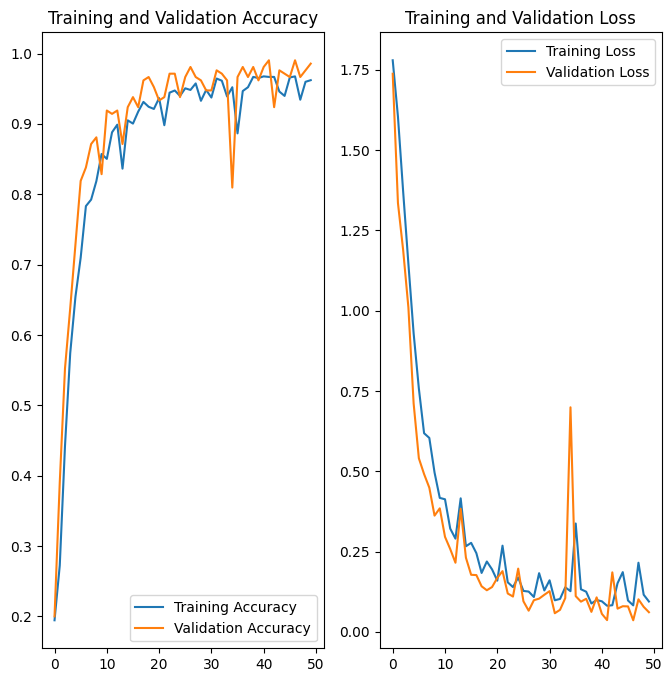

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Patches
1/1 [==============================] - 0s 294ms/step
predicted label: Patches


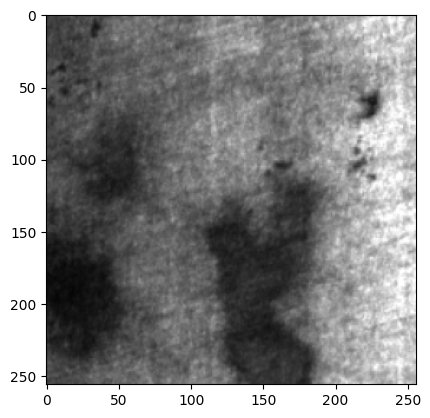

In [78]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",c_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",c_names[np.argmax(batch_prediction[0])])

In [79]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = c_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


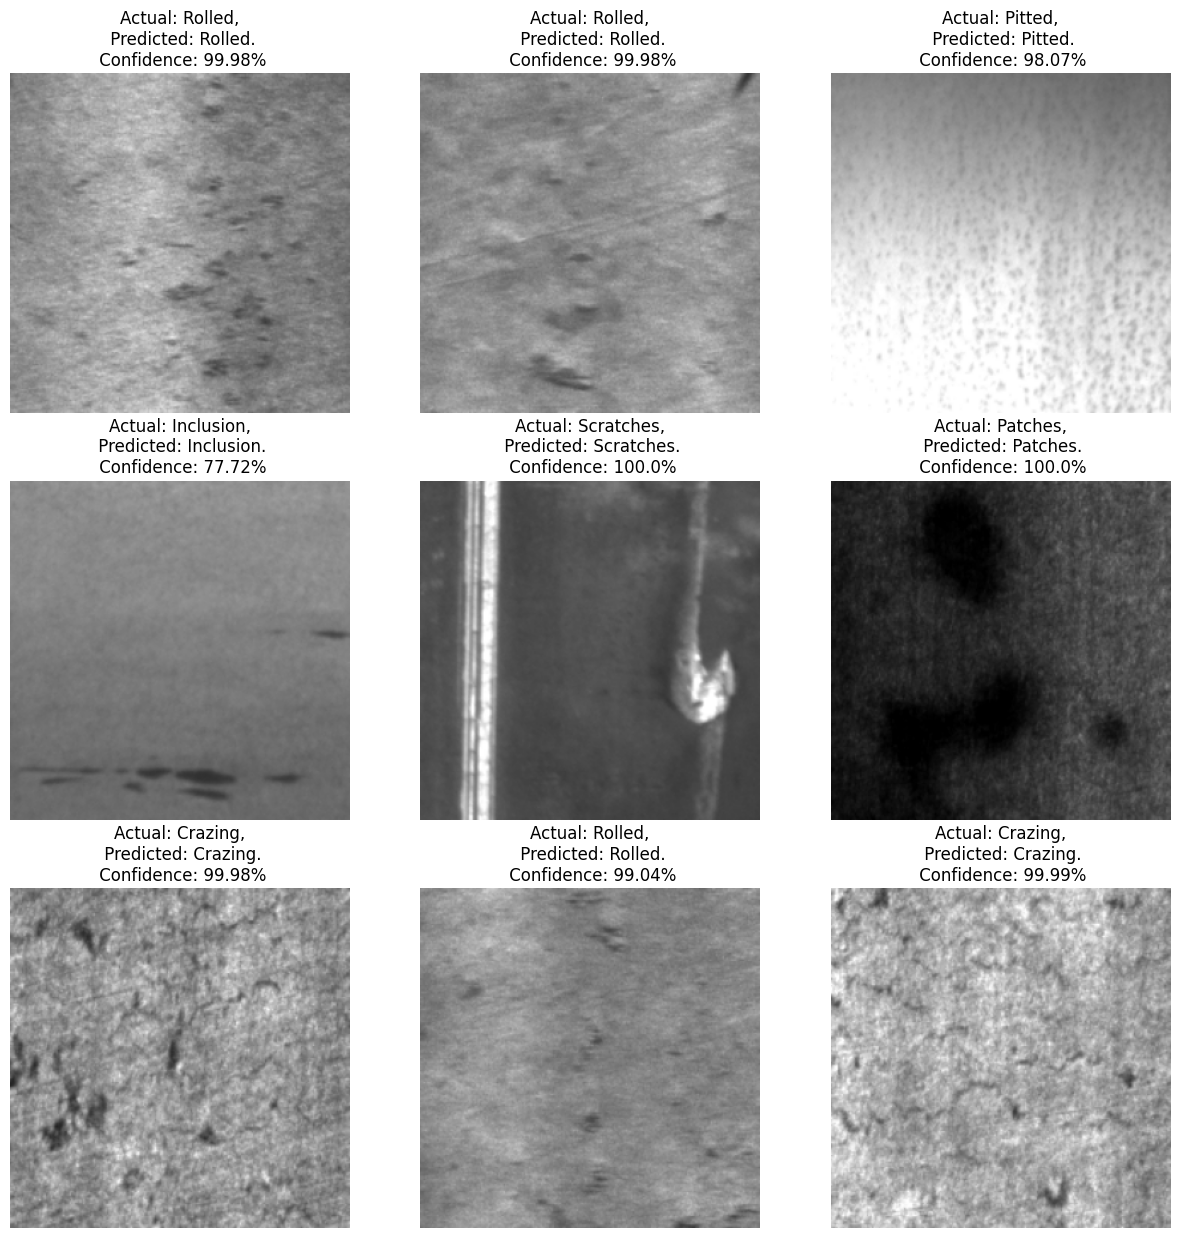

In [80]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = c_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [83]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
